In [1]:
import os
import json
import h5py
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
#Data path
PATH = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'

DATA_PATH = PATH + 'DATA/'


In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)
BIN_SIZE = 5
GRID_SIZE = 300
DATA_SIZE = 400000
#float64
REDSHIFT_GRID = numpy.linspace(0.005, 2.995, 300)
# Load
with h5py.File(os.path.join(synthesize_folder, '{}/{}_{}.hdf5'.format(tag, typ, label)), 'r') as file:
    LENS_GRID = numpy.array(file['lens']['data'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'double')

In [4]:
# Cosmology
# COSMOLOGY

with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    
    COSMO = json.load(file)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu=COSMO['M_NU'],
    Neff = COSMO['N_EFF'],
    Omega_k = COSMO['OMEGA_K'], 
    Omega_c = COSMO['OMEGA_CDM'], 
    Omega_b = COSMO['OMEGA_B'], 
    Omega_g=COSMO['OMEGA_GAMMA'],
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [5]:
#Define Phi

def phi_m(chi_data, chi_grid, phi_grid):

    bin_size = phi_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    phi = numpy.zeros((bin_size, data_size + 1))

    for k in range(data_size + 1):
        
        n = numpy.max(numpy.where(chi_grid <= chi_data[k]))

        if n < grid_size:

            phi[:,k] = (chi_grid[n + 1] - chi_data[k]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n] + (chi_data[k] - chi_grid[n]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n + 1]
        else:

            phi[:,k] = 0.0
    
    return phi

In [6]:
#Compare different numeric equations

LENS_PSI_GRID = numpy.mean(LENS_GRID, axis = 0)
LENS_SIGMA_GRID = numpy.std(LENS_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'double')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

CHI_SIZE = 1000
REDSHIFT_DATA = numpy.linspace(REDSHIFT_GRID.min(), REDSHIFT_GRID.max(), CHI_SIZE + 1)

CHI_DATA = COSMO_CCL.comoving_radial_distance(a = 1 / (1 + REDSHIFT_DATA))
A_DATA = pyccl.background.scale_factor_of_chi(cosmo = COSMO_CCL, chi = CHI_DATA)

PHI_CCL = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
for BIN_INDEX in range(BIN_SIZE):

    TRACER = pyccl.tracers.WeakLensingTracer(cosmo = COSMO_CCL, dndz = [REDSHIFT_GRID, LENS_PSI_GRID[BIN_INDEX,:]], has_shear = True, ia_bias = None, use_A_ia = False, n_samples = GRID_SIZE)
    PHI_CCL[BIN_INDEX,:] = TRACER.get_dndz(REDSHIFT_DATA) * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_DATA)) * COSMO['H'] * 100000 / scipy.constants.c

PHI_DATA1 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind = 'slinear')(CHI_DATA)
PHI_DATA2 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind = 'quadratic')(CHI_DATA)
PHI_DATA3 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind = 'cubic')(CHI_DATA)
PHI_DATA = phi_m(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_grid = LENS_PHI_GRID)

PHI_RATIO = numpy.divide(PHI_DATA, PHI_CCL, out = numpy.ones(PHI_CCL.shape), where = PHI_CCL > 0)
PHI_RATIO1 = numpy.divide(PHI_DATA1, PHI_CCL, out = numpy.ones(PHI_CCL.shape), where = PHI_CCL > 0)
PHI_RATIO2 = numpy.divide(PHI_DATA2, PHI_CCL, out = numpy.ones(PHI_CCL.shape), where = PHI_CCL > 0)
PHI_RATIO3 = numpy.divide(PHI_DATA3, PHI_CCL, out = numpy.ones(PHI_CCL.shape), where = PHI_CCL > 0)

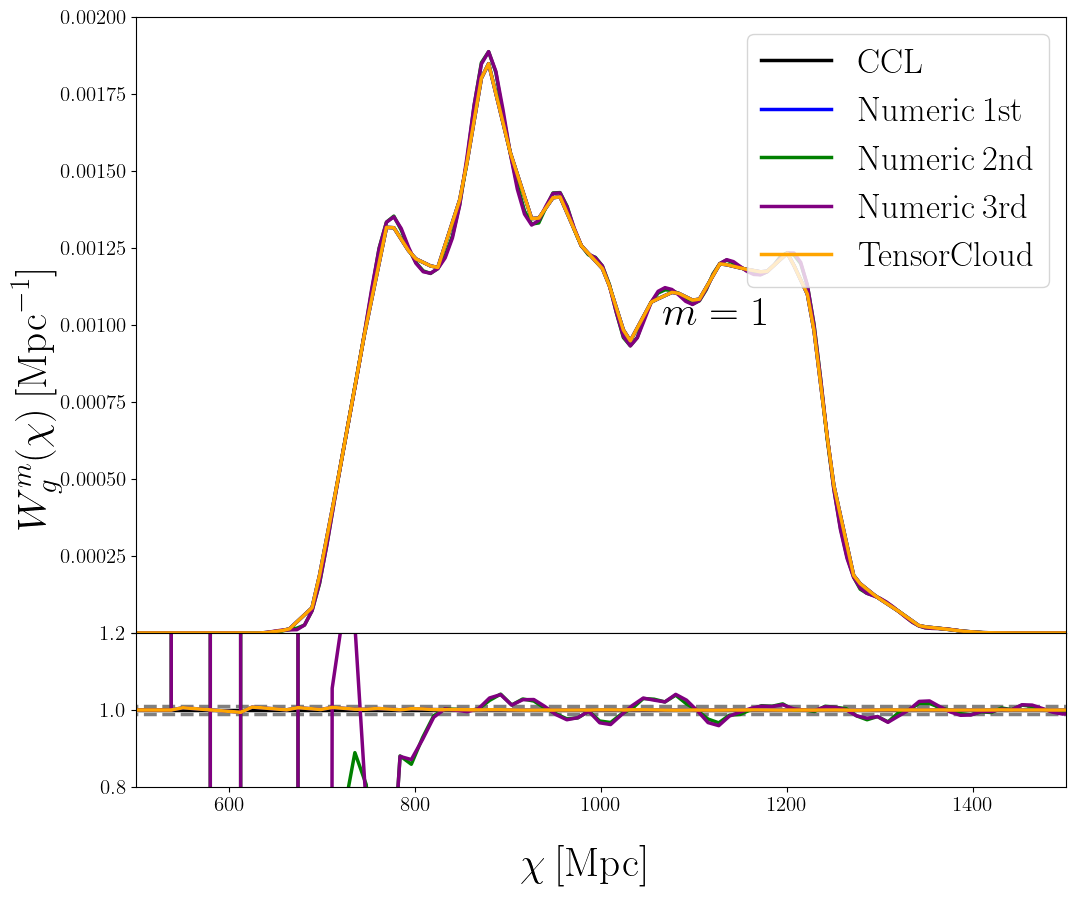

In [7]:
#Plot the results

BIN_INDEX = 0
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[0:8,:])

PLOT.plot(CHI_DATA, PHI_CCL[BIN_INDEX,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(CHI_DATA, PHI_DATA1[BIN_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(CHI_DATA, PHI_DATA2[BIN_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')

PLOT.plot(CHI_DATA, PHI_DATA3[BIN_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(CHI_DATA, PHI_DATA[BIN_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 1350, y = 0.001, s = r'$m = {:.0f}$'.format(BIN_INDEX + 1), fontsize = 30)

PLOT.set_xlim(500, 2000)
PLOT.set_ylim(0.000, 0.002)
PLOT.legend(loc = 'upper right', fontsize = 25)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])

PLOT = FIGURE.add_subplot(GRIDSPEC[8:,:])

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, PHI_RATIO1[BIN_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, PHI_RATIO2[BIN_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, PHI_RATIO3[BIN_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, PHI_RATIO[BIN_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xlim(500, 1500)
PLOT.set_ylim(0.80, 1.20)
PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$W_g^m (\chi) \: [\mathrm{Mpc}^{-1}]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Wg.png')
FIGURE.show()